In [2]:
import sys
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
import plotly.io as pio
sys.path.append("/kaggle/input/lib-power-prediction")
from lib.utils import preprocess_compact, load_process_block_compact, map_weather_holidays

# cài đặt chung
pio.templates.default = "plotly_white"
np.random.seed()
tqdm.pandas()


In [12]:
source_data = Path("/kaggle/input/smart-meters-in-london/hhblock_dataset")
preprocessed_data = source_data/"hhblock_dataset"
preprocessed_data

PosixPath('/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset')

In [11]:
block_1 = pd.read_csv(preprocessed_data/"block_0.csv", parse_dates=False)
block_1['day'] = pd.to_datetime(block_1['day'], yearfirst=True)
block_1.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,2012-10-13,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,2012-10-14,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,2012-10-15,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,2012-10-16,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,2012-10-17,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


In [13]:
#Check End Dates of all time series
block_1.groupby("LCLid")['day'].max().sample(5)

LCLid
MAC005492   2014-02-27
MAC004319   2014-02-27
MAC003844   2014-02-27
MAC004247   2014-02-27
MAC003400   2014-02-27
Name: day, dtype: datetime64[ns]

In [6]:
max_date = None
for f in tqdm(preprocessed_data.glob("*.csv")):
    df = pd.read_csv(f, parse_dates=False)
    df['day'] = pd.to_datetime(df['day'], yearfirst=True)
    if max_date is None:
        max_date = df['day'].max()
    else:
        if df['day'].max()>max_date:
            max_date = df['day'].max()
print(f"Max Date across all blocks: {max_date}")
del df

0it [00:00, ?it/s]

Max Date across all blocks: 2014-02-27 00:00:00


In [14]:
#Reshaping the dataframe into the long form with hour blocks along the rows
block_1 = block_1.set_index(['LCLid', "day"]).stack().reset_index().rename(columns={"level_2": "hour_block", 0: "energy_consumption"})
#Creating a numerical hourblock column
block_1['offset'] = block_1['hour_block'].str.replace("hh_", "").astype(int)

block_1.head()

,LCLid,day,hour_block,energy_consumption,offset
0,MAC000002,2012-10-13,hh_0,0.263,0
1,MAC000002,2012-10-13,hh_1,0.269,1
2,MAC000002,2012-10-13,hh_2,0.275,2
3,MAC000002,2012-10-13,hh_3,0.256,3
4,MAC000002,2012-10-13,hh_4,0.211,4


In [15]:
block_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213678 entries, 0 to 1213677
Data columns (total 5 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   LCLid               1213678 non-null  object        
 1   day                 1213678 non-null  datetime64[ns]
 2   hour_block          1213678 non-null  object        
 3   energy_consumption  1213678 non-null  float64       
 4   offset              1213678 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 46.3+ MB


In [16]:
# Put all collected data into a compact row for each household to reduce memory space
preprocess_compact(block_1, max_date)

(Timestamp('2011-12-04 00:00:00'),
 'MAC000002',
 array([0.175, 0.098, 0.144, ..., 0.073, 0.258, 0.192]),
 1213678)

In [17]:
block1_compact = load_process_block_compact(block_1, max_date, freq="30min", ts_identifier="LCLid", value_name="energy_consumption")

  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
block1_compact.head()

,LCLid,start_timestamp,frequency,energy_consumption,series_length
0,MAC000002,2012-10-13,30min,"[0.263, 0.2689999999999999, 0.275, 0.256, 0.21...",24144
1,MAC000246,2011-12-04,30min,"[0.175, 0.098, 0.144, 0.065, 0.071, 0.037, 0.0...",39216
2,MAC000450,2012-03-23,30min,"[1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...",33936
3,MAC001074,2012-05-09,30min,"[0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...",31680
4,MAC003223,2012-09-18,30min,"[0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...",25344


In [19]:
del block_1, block1_compact

In [20]:
# Read all blocks to one list
block_df_l = []
data_dir = Path("/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset")

for file in tqdm(sorted(list(data_dir.glob("*.csv"))), desc="Processing Blocks.."):
    block_df = pd.read_csv(file, parse_dates=False)
    block_df['day'] = pd.to_datetime(block_df['day'], yearfirst=True)
    # Taking only from 2012-01-01
    block_df = block_df.loc[block_df['day']>="2012-01-01"]
    #Reshaping the dataframe into the long form with hour blocks along the rows
    block_df = block_df.set_index(['LCLid', "day"]).stack().reset_index().rename(columns={"level_2": "hour_block", 0: "energy_consumption"})
    #Creating a numerical hourblock column
    block_df['offset'] = block_df['hour_block'].str.replace("hh_", "").astype(int)
    block_df_l.append(load_process_block_compact(block_df, max_date, freq="30min", ts_identifier="LCLid", value_name="energy_consumption"))

Processing Blocks..:   0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
# Combine all blocks data to one dataframe
hhblock_df = pd.concat(block_df_l)
del block_df_l

In [22]:
hhblock_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5560 entries, 0 to 49
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   LCLid               5560 non-null   object        
 1   start_timestamp     5560 non-null   datetime64[ns]
 2   frequency           5560 non-null   object        
 3   energy_consumption  5560 non-null   object        
 4   series_length       5560 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 260.6+ KB


In [23]:
hhblock_df.head()

,LCLid,start_timestamp,frequency,energy_consumption,series_length
0,MAC000002,2012-10-13,30min,"[0.263, 0.2689999999999999, 0.275, 0.256, 0.21...",24144
1,MAC000246,2012-01-01,30min,"[0.509, 0.317, 0.253, 0.249, 0.93, 0.607, 0.10...",37872
2,MAC000450,2012-03-23,30min,"[1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...",33936
3,MAC001074,2012-05-09,30min,"[0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...",31680
4,MAC003223,2012-09-18,30min,"[0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...",25344


In [24]:
household_info = pd.read_csv("/kaggle/input/smart-meters-in-london/informations_households.csv")
household_info.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [25]:
hhblock_df = hhblock_df.merge(household_info, on='LCLid', validate="one_to_one")
hhblock_df.head()

,LCLid,start_timestamp,frequency,energy_consumption,series_length,stdorToU,Acorn,Acorn_grouped,file
0,MAC000002,2012-10-13,30min,"[0.263, 0.2689999999999999, 0.275, 0.256, 0.21...",24144,Std,ACORN-A,Affluent,block_0
1,MAC000246,2012-01-01,30min,"[0.509, 0.317, 0.253, 0.249, 0.93, 0.607, 0.10...",37872,Std,ACORN-A,Affluent,block_0
2,MAC000450,2012-03-23,30min,"[1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...",33936,Std,ACORN-A,Affluent,block_0
3,MAC001074,2012-05-09,30min,"[0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...",31680,ToU,ACORN-,ACORN-,block_0
4,MAC003223,2012-09-18,30min,"[0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...",25344,Std,ACORN-A,Affluent,block_0


In [26]:
bank_holidays = pd.read_csv("/kaggle/input/smart-meters-in-london/uk_bank_holidays.csv", parse_dates=False)
bank_holidays['Bank holidays'] = pd.to_datetime(bank_holidays['Bank holidays'], yearfirst=True)
bank_holidays.set_index("Bank holidays", inplace=True)
bank_holidays.head()

,Type
Bank holidays,
2012-12-26,Boxing Day
2012-12-25,Christmas Day
2012-08-27,Summer bank holiday
2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
2012-04-06,Spring bank holiday (substitute day)


In [27]:
#Reindex on standard date range
bank_holidays = bank_holidays.resample("30min").asfreq()
bank_holidays = bank_holidays.groupby(bank_holidays.index.date).ffill().fillna("NO_HOLIDAY")
bank_holidays.index.name="datetime"
bank_holidays.head()

,Type
datetime,
2012-02-01 00:00:00,New Year?s Day (substitute day)
2012-02-01 00:30:00,New Year?s Day (substitute day)
2012-02-01 01:00:00,New Year?s Day (substitute day)
2012-02-01 01:30:00,New Year?s Day (substitute day)
2012-02-01 02:00:00,New Year?s Day (substitute day)


In [28]:
weather_hourly = pd.read_csv("/kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv", parse_dates=False)
weather_hourly['time'] = pd.to_datetime(weather_hourly['time'], yearfirst=True)
weather_hourly.set_index("time", inplace=True)
weather_hourly.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
time,,,,,,,,,,,
2011-11-11 00:00:00,5.97,104,10.24,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
2011-11-11 01:00:00,4.88,99,9.76,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2011-11-11 02:00:00,3.70,98,9.46,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
2011-11-11 03:00:00,3.12,99,9.23,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
2011-11-11 04:00:00,1.85,111,9.26,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


In [29]:
#Resampling at 30min and forward fill
weather_hourly = weather_hourly.resample("30min").ffill()
weather_hourly.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
time,,,,,,,,,,,
2011-11-01 00:00:00,13.63,160,13.49,11.48,1008.14,13.49,3.11,rain,clear-night,0.88,Clear
2011-11-01 00:30:00,13.63,160,13.49,11.48,1008.14,13.49,3.11,rain,clear-night,0.88,Clear
2011-11-01 01:00:00,13.26,154,12.73,11.58,1007.88,12.73,3.08,rain,partly-cloudy-night,0.93,Partly Cloudy
2011-11-01 01:30:00,13.26,154,12.73,11.58,1007.88,12.73,3.08,rain,partly-cloudy-night,0.93,Partly Cloudy
2011-11-01 02:00:00,12.94,161,13.65,12.14,1007.09,13.65,3.71,rain,clear-night,0.91,Clear


In [30]:
hhblock_df = hhblock_df.progress_apply(lambda row: map_weather_holidays(row, bank_holidays, weather_hourly), axis=1)
hhblock_df.head()

  0%|          | 0/5560 [00:00<?, ?it/s]

,LCLid,start_timestamp,frequency,energy_consumption,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,MAC000002,2012-10-13,30min,"[0.263, 0.2689999999999999, 0.275, 0.256, 0.21...",24144,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[186, 186, 188, 188, 190, 190, 203, 203, 206, ...","[8.78, 8.78, 8.27, 8.27, 7.87, 7.87, 7.89, 7.8...","[6.28, 6.28, 6.21, 6.21, 6.22, 6.22, 6.76, 6.7...","[1007.7, 1007.7, 1007.36, 1007.36, 1006.73, 10...","[7.55, 7.55, 7.34, 7.34, 6.75, 6.75, 6.89, 6.8...","[2.28, 2.28, 1.81, 1.81, 1.95, 1.95, 1.83, 1.8...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.84, 0.84, 0.87, 0.87, 0.89, 0.89, 0.93, 0.9...","[Clear, Clear, Clear, Clear, Partly Cloudy, Pa..."
1,MAC000246,2012-01-01,30min,"[0.509, 0.317, 0.253, 0.249, 0.93, 0.607, 0.10...",37872,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[229, 229, 238, 238, 229, 229, 231, 231, 227, ...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....","[1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, clo...","[0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.93,...","[Mostly Cloudy, Mostly Cloudy, Overcast, Overc..."
2,MAC000450,2012-03-23,30min,"[1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...",33936,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[78, 78, 73, 73, 81, 81, 80, 80, 75, 75, 71, 7...","[8.76, 8.76, 8.54, 8.54, 8.09, 8.09, 7.34, 7.3...","[7.25, 7.25, 7.12, 7.12, 7.17, 7.17, 6.68, 6.6...","[1027.41, 1027.41, 1026.91, 1026.91, 1026.54, ...","[7.59, 7.59, 7.43, 7.43, 7.24, 7.24, 7.34, 7.3...","[2.18, 2.18, 2.07, 2.07, 1.72, 1.72, 1.34, 1.3...","[rain, rain, rain, rain, rain, rain, rain, rai...","[fog, fog, fog, fog, fog, fog, fog, fog, fog, ...","[0.9, 0.9, 0.91, 0.91, 0.94, 0.94, 0.96, 0.96,...","[Foggy, Foggy, Foggy, Foggy, Foggy, Foggy, Fog..."
3,MAC001074,2012-05-09,30min,"[0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...",31680,ToU,ACORN-,ACORN-,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[215, 215, 207, 207, 215, 215, 216, 216, 126, ...","[11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....","[10.23, 10.23, 10.17, 10.17, 10.24, 10.24, 10....","[1007.39, 1007.39, 1007.21, 1007.21, 1007.06, ...","[11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....","[2.35, 2.35, 2.15, 2.15, 1.84, 1.84, 1.22, 1.2...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, par...","[0.92, 0.92, 0.92, 0.92, 0.93, 0.93, 0.95, 0.9...","[Partly Cloudy, Partly Cloudy, Mostly Cloudy, ..."
4,MAC003223,2012-09-18,30min,"[0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...",25344,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[236, 236, 240, 240, 242, 242, 244, 244, 248, ...","[14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....","[10.82, 10.82, 10.29, 10.29, 9.86, 9.86, 9.83,...","[1011.09, 1011.09, 1010.82, 1010.82, 1010.65, ...","[14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....","[3.86, 3.86, 3.81, 3.81, 4.27, 4.27, 4.12, 4.1...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.81, 0.81, 0.83, 0.83, 0.84, 0.84, 0.86, 0.8...","[Clear, Clear, Clear, Clear, Clear, Clear, Par..."


In [31]:
del block_df, weather_hourly, bank_holidays, household_info

In [32]:
hhblock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5560 entries, 0 to 5559
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   LCLid                5560 non-null   object        
 1   start_timestamp      5560 non-null   datetime64[ns]
 2   frequency            5560 non-null   object        
 3   energy_consumption   5560 non-null   object        
 4   series_length        5560 non-null   int64         
 5   stdorToU             5560 non-null   object        
 6   Acorn                5560 non-null   object        
 7   Acorn_grouped        5560 non-null   object        
 8   file                 5560 non-null   object        
 9   holidays             5560 non-null   object        
 10  visibility           5560 non-null   object        
 11  windBearing          5560 non-null   object        
 12  temperature          5560 non-null   object        
 13  dewPoint             5560 non-nul

In [33]:
display(hhblock_df.memory_usage(deep=True))
print(f"Total: {hhblock_df.memory_usage(deep=True).sum()/1024**2} MB")

Index                     132
LCLid                  366960
start_timestamp         44480
frequency              344720
energy_consumption     667200
series_length           44480
stdorToU               333600
Acorn                  355838
Acorn_grouped          367675
file                   361465
holidays               667200
visibility             667200
windBearing            667200
temperature            667200
dewPoint               667200
pressure               667200
apparentTemperature    667200
windSpeed              667200
precipType             667200
icon                   667200
humidity               667200
summary                667200
dtype: int64

Total: 10.388326644897461 MB


In [34]:
# Saving the LCLid - Acorn map as a pickle to be used later
from pathlib import Path
data_out = Path("/kaggle/working/")

hhblock_df[['LCLid',"file", "Acorn_grouped"]].to_pickle(data_out/"london_smart_meters_lclid_acorn_map.pkl")

In [35]:
# Splitting the blocks into 8 chunks
blocks = [f"block_{i}" for i in range(111)]

n_chunks= 8
split_blocks = [blocks[i:i + n_chunks] for i in range(0, len(blocks), n_chunks)]

#Writing each chunk to disk
for blk in tqdm(split_blocks):
    df = hhblock_df.loc[hhblock_df.file.isin(blk)]
    blk = [int(b.replace("block_","")) for b in blk]
    block_str = f"block_{min(blk)}-{max(blk)}"
    df.to_parquet(data_out/f"london_smart_meters_merged_{block_str}.parquet")

  0%|          | 0/14 [00:00<?, ?it/s]

Explore the dataset characteristics

In [36]:
import sys
sys.path.append("/kaggle/input/lib-power-prediction")
from lib.utils import compact_to_expanded, format_plot, imputation, update_figure_layout, decomposition_plot
from lib.utils import two_line_plot_secondary_axis, plot_autocorrelation
import seaborn as sns
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import missingno as msno
from sklearn.metrics import mean_absolute_error
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
# %load_ext autoreload
# %autoreload 2
np.random.seed()
tqdm.pandas()

In [37]:
block_df = pd.read_parquet("/kaggle/input/data-output-power-prediction/london_smart_meters_merged_block_0-7.parquet")
display(block_df.head())

,LCLid,start_timestamp,frequency,energy_consumption,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,MAC000002,2012-10-13,30min,"[0.263, 0.2689999999999999, 0.275, 0.256, 0.21...",24144,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[186, 186, 188, 188, 190, 190, 203, 203, 206, ...","[8.78, 8.78, 8.27, 8.27, 7.87, 7.87, 7.89, 7.8...","[6.28, 6.28, 6.21, 6.21, 6.22, 6.22, 6.76, 6.7...","[1007.7, 1007.7, 1007.36, 1007.36, 1006.73, 10...","[7.55, 7.55, 7.34, 7.34, 6.75, 6.75, 6.89, 6.8...","[2.28, 2.28, 1.81, 1.81, 1.95, 1.95, 1.83, 1.8...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.84, 0.84, 0.87, 0.87, 0.89, 0.89, 0.93, 0.9...","[Clear, Clear, Clear, Clear, Partly Cloudy, Pa..."
1,MAC000246,2012-01-01,30min,"[0.509, 0.317, 0.253, 0.249, 0.93, 0.607, 0.10...",37872,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[229, 229, 238, 238, 229, 229, 231, 231, 227, ...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....","[1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, clo...","[0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.93,...","[Mostly Cloudy, Mostly Cloudy, Overcast, Overc..."
2,MAC000450,2012-03-23,30min,"[1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...",33936,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[78, 78, 73, 73, 81, 81, 80, 80, 75, 75, 71, 7...","[8.76, 8.76, 8.54, 8.54, 8.09, 8.09, 7.34, 7.3...","[7.25, 7.25, 7.12, 7.12, 7.17, 7.17, 6.68, 6.6...","[1027.41, 1027.41, 1026.91, 1026.91, 1026.54, ...","[7.59, 7.59, 7.43, 7.43, 7.24, 7.24, 7.34, 7.3...","[2.18, 2.18, 2.07, 2.07, 1.72, 1.72, 1.34, 1.3...","[rain, rain, rain, rain, rain, rain, rain, rai...","[fog, fog, fog, fog, fog, fog, fog, fog, fog, ...","[0.9, 0.9, 0.91, 0.91, 0.94, 0.94, 0.96, 0.96,...","[Foggy, Foggy, Foggy, Foggy, Foggy, Foggy, Fog..."
3,MAC001074,2012-05-09,30min,"[0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...",31680,ToU,ACORN-,ACORN-,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[215, 215, 207, 207, 215, 215, 216, 216, 126, ...","[11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....","[10.23, 10.23, 10.17, 10.17, 10.24, 10.24, 10....","[1007.39, 1007.39, 1007.21, 1007.21, 1007.06, ...","[11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....","[2.35, 2.35, 2.15, 2.15, 1.84, 1.84, 1.22, 1.2...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, par...","[0.92, 0.92, 0.92, 0.92, 0.93, 0.93, 0.95, 0.9...","[Partly Cloudy, Partly Cloudy, Mostly Cloudy, ..."
4,MAC003223,2012-09-18,30min,"[0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...",25344,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[236, 236, 240, 240, 242, 242, 244, 244, 248, ...","[14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....","[10.82, 10.82, 10.29, 10.29, 9.86, 9.86, 9.83,...","[1011.09, 1011.09, 1010.82, 1010.82, 1010.65, ...","[14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....","[3.86, 3.86, 3.81, 3.81, 4.27, 4.27, 4.12, 4.1...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.81, 0.81, 0.83, 0.83, 0.84, 0.84, 0.86, 0.8...","[Clear, Clear, Clear, Clear, Clear, Clear, Par..."


In [38]:
display(block_df[block_df.file == "block_7"].head())

,LCLid,start_timestamp,frequency,energy_consumption,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
3912,MAC000050,2012-01-01,30min,"[0.175, 0.212, 0.313, 0.302, 0.257, 0.179, 0.1...",37872,Std,ACORN-D,Affluent,block_7,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[229, 229, 238, 238, 229, 229, 231, 231, 227, ...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....","[1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, clo...","[0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.93,...","[Mostly Cloudy, Mostly Cloudy, Overcast, Overc..."
3913,MAC000063,2012-01-01,30min,"[0.048, 0.047, 0.047, 0.047, 0.048, 0.073, 0.0...",37872,Std,ACORN-D,Affluent,block_7,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[229, 229, 238, 238, 229, 229, 231, 231, 227, ...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....","[1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, clo...","[0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.93,...","[Mostly Cloudy, Mostly Cloudy, Overcast, Overc..."
3914,MAC000073,2012-01-01,30min,"[0.054, 0.057, 0.0579999999999999, 0.166, 0.08...",37872,Std,ACORN-D,Affluent,block_7,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[229, 229, 238, 238, 229, 229, 231, 231, 227, ...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....","[1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, clo...","[0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.93,...","[Mostly Cloudy, Mostly Cloudy, Overcast, Overc..."
3915,MAC000084,2012-01-01,30min,"[0.319, 0.312, 0.33, 0.236, 0.2019999999999999...",37872,Std,ACORN-D,Affluent,block_7,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[229, 229, 238, 238, 229, 229, 231, 231, 227, ...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....","[1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, clo...","[0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.93,...","[Mostly Cloudy, Mostly Cloudy, Overcast, Overc..."
3916,MAC000193,2012-01-01,30min,"[0.368, 0.386, 0.17, 0.021, 0.038, 0.038, 0.02...",37872,ToU,ACORN-D,Affluent,block_7,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[229, 229, 238, 238, 229, 229, 231, 231, 227, ...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....","[1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, clo...","[0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.93,...","[Mostly Cloudy, Mostly Cloudy, Overcast, Overc..."


In [39]:
#Converting to expanded form
exp_block_df = compact_to_expanded(block_df[block_df.file=="block_7"], timeseries_col = 'energy_consumption',
static_cols = ["frequency", "series_length", "stdorToU", "Acorn", "Acorn_grouped", "file"],
time_varying_cols = ['holidays', 'visibility', 'windBearing', 'temperature', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary'],
ts_identifier = "LCLid")

exp_block_df.head()

  0%|          | 0/50 [00:00<?, ?it/s]

,timestamp,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,2012-01-01 00:00:00,MAC000050,0.175,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
1,2012-01-01 00:30:00,MAC000050,0.212,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
2,2012-01-01 01:00:00,MAC000050,0.313,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
3,2012-01-01 01:30:00,MAC000050,0.302,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
4,2012-01-01 02:00:00,MAC000050,0.257,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,229,12.45,11.04,1007.95,12.45,5.31,rain,partly-cloudy-night,0.91,Mostly Cloudy


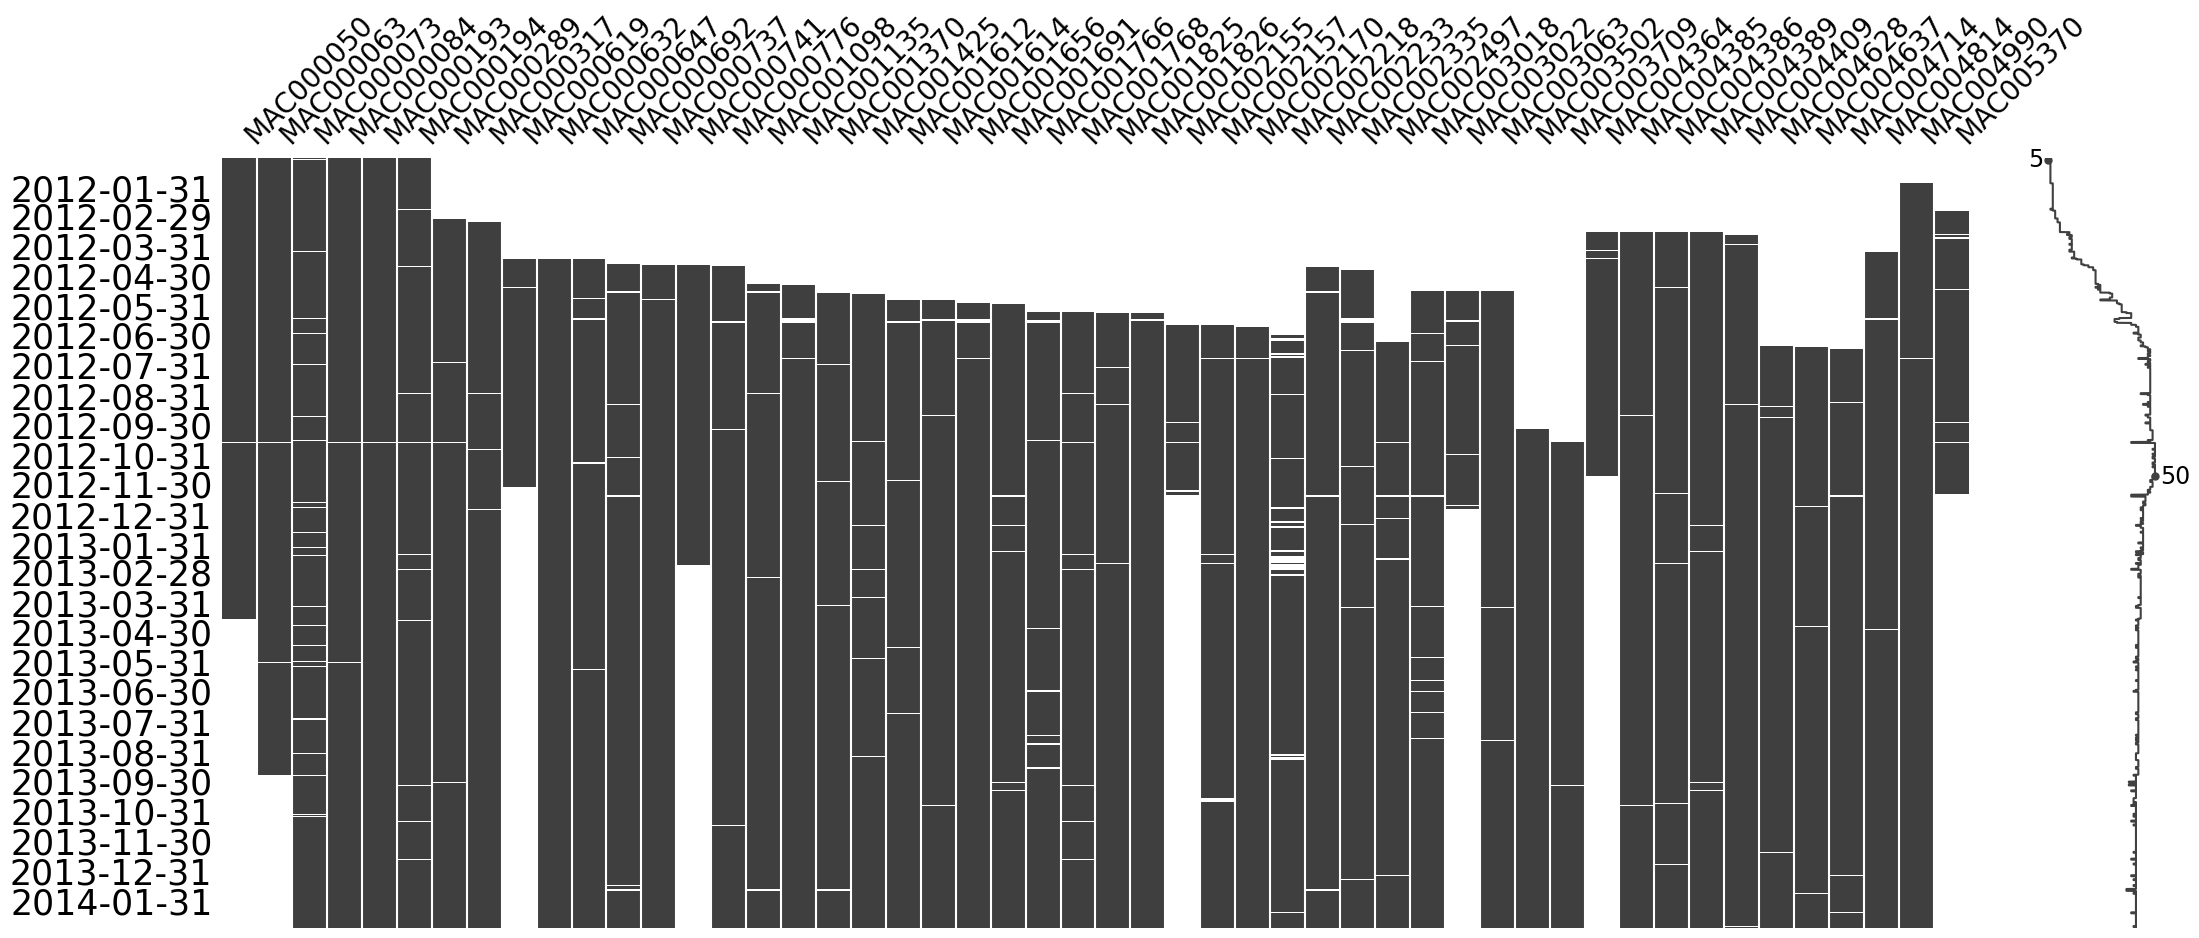

In [40]:
# Pivot the data
plot_df = pd.pivot_table(
    exp_block_df, 
    index="timestamp", 
    columns="LCLid", 
    values="energy_consumption"
)

# Vẽ missingno matrix
msno.matrix(plot_df, freq="ME", fontsize=20)

# Lưu hình vào Kaggle working
plt.savefig("/kaggle/working/missing_no_full.png", bbox_inches='tight')

# Hiển thị trên notebook
plt.show()

In [41]:
# Taking a single time series from the block
ts_df = exp_block_df[exp_block_df.LCLid=="MAC000193"].set_index("timestamp")

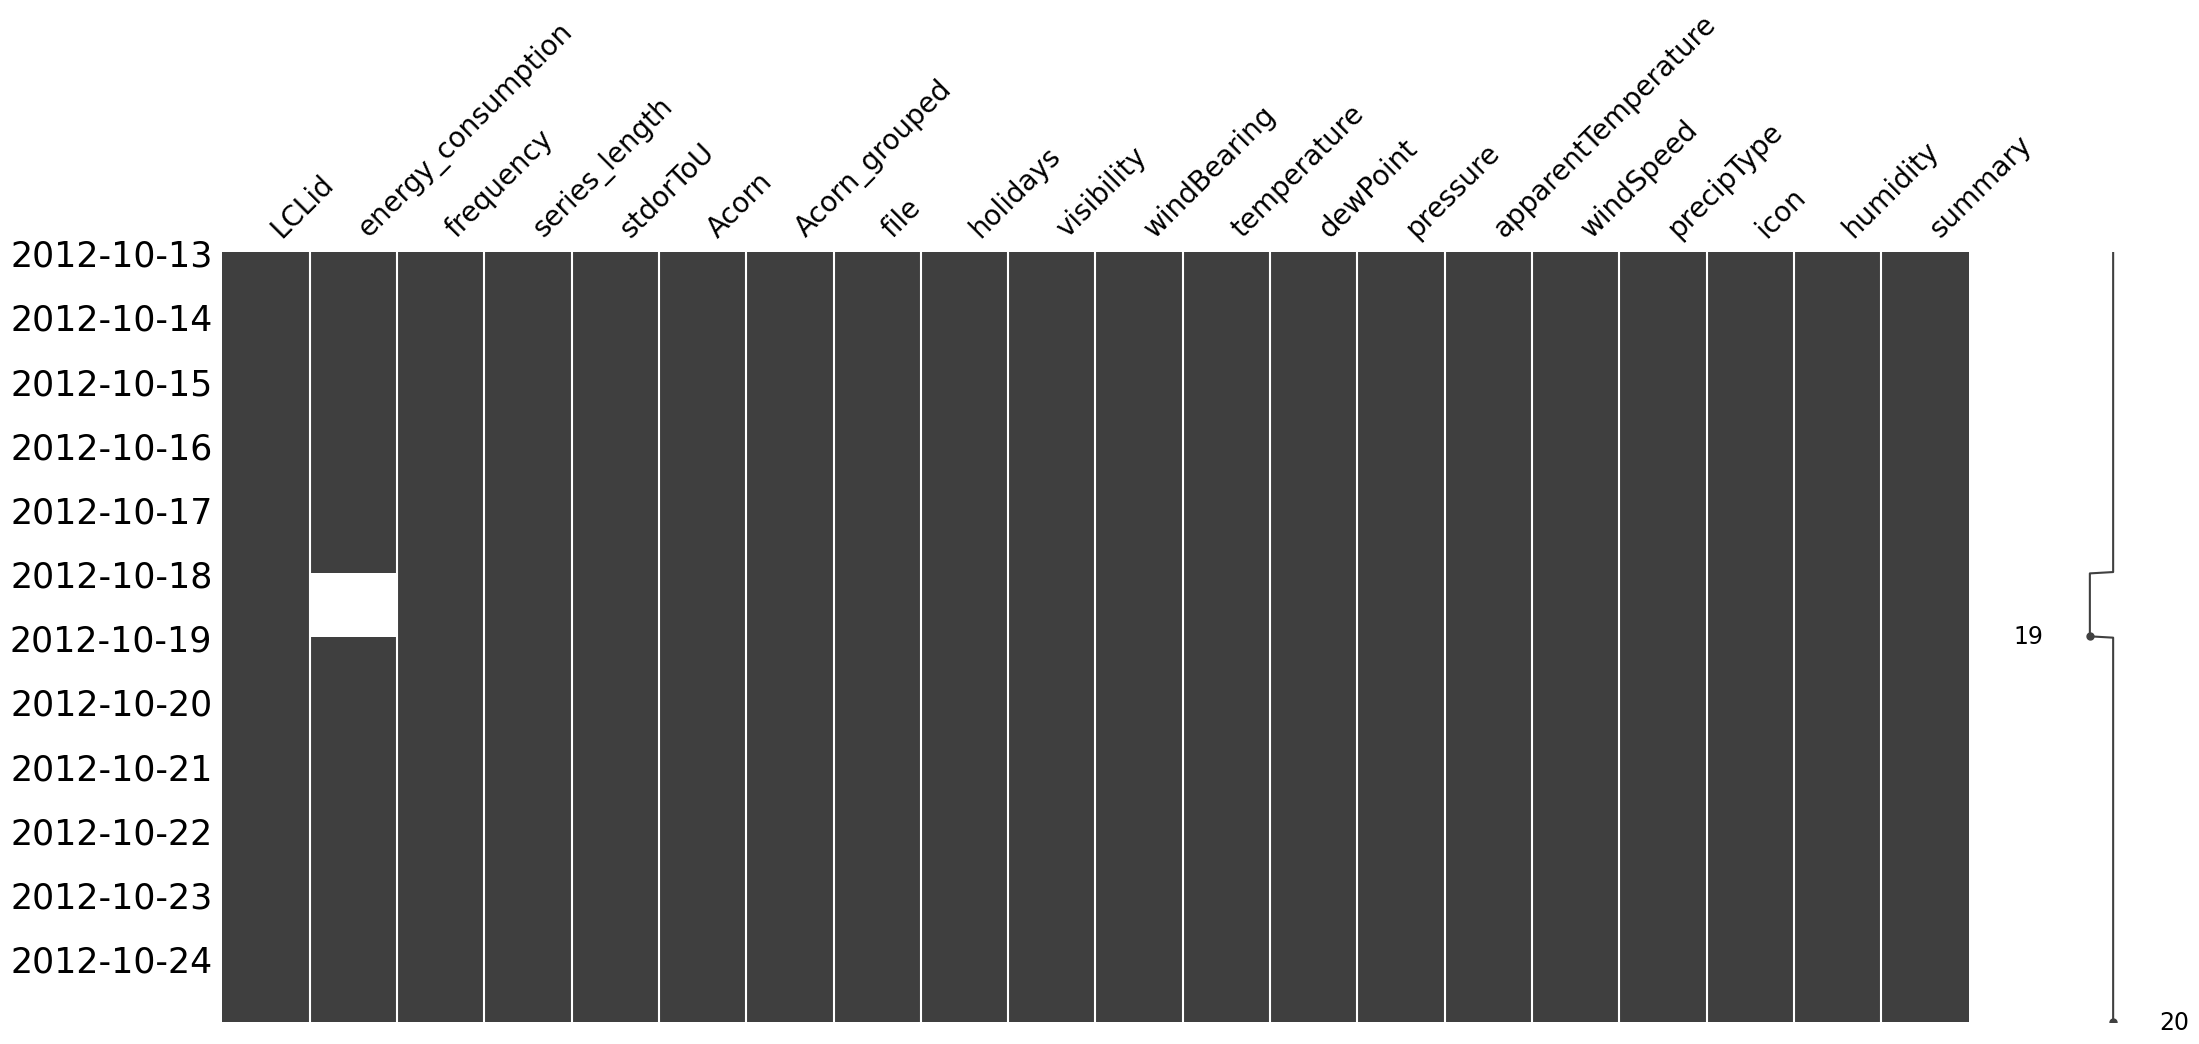

In [42]:
msno.matrix(ts_df["2012-10-13":"2012-10-24"], freq="D", fontsize=20)

plt.savefig("/kaggle/working/missing_no_mac000193.png", bbox_inches='tight')

plt.show()


In [43]:
ts_df2 = ts_df.copy()
ts_df2

,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
timestamp,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,MAC000193,0.368,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.99,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
2012-01-01 00:30:00,MAC000193,0.386,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.99,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
2012-01-01 01:00:00,MAC000193,0.170,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.89,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
2012-01-01 01:30:00,MAC000193,0.021,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.89,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
2012-01-01 02:00:00,MAC000193,0.038,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,11.54,229,12.45,11.04,1007.95,12.45,5.31,rain,partly-cloudy-night,0.91,Mostly Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 21:30:00,MAC000193,0.217,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,16.09,217,5.03,1.67,1006.36,2.50,3.06,rain,clear-night,0.79,Clear
2014-02-27 22:00:00,MAC000193,0.169,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,14.00,216,4.10,1.64,1005.67,1.41,3.02,rain,clear-night,0.84,Clear
2014-02-27 22:30:00,MAC000193,0.268,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,14.00,216,4.10,1.64,1005.67,1.41,3.02,rain,clear-night,0.84,Clear


In [44]:
# The dates between which we are nulling out the time series
window = slice("2012-10-07", "2012-10-08")
# Creating a new column and artificially creating missing values
ts_df2['energy_consumption_missing'] = ts_df2.energy_consumption
ts_df2.loc[window, "energy_consumption_missing"] = np.nan
# Creating a new window with a few dates added on either side for visualization purposes
vis_window = slice(pd.to_datetime(window.start) - pd.Timedelta(days=2), pd.to_datetime(window.stop) + pd.Timedelta(days=2))

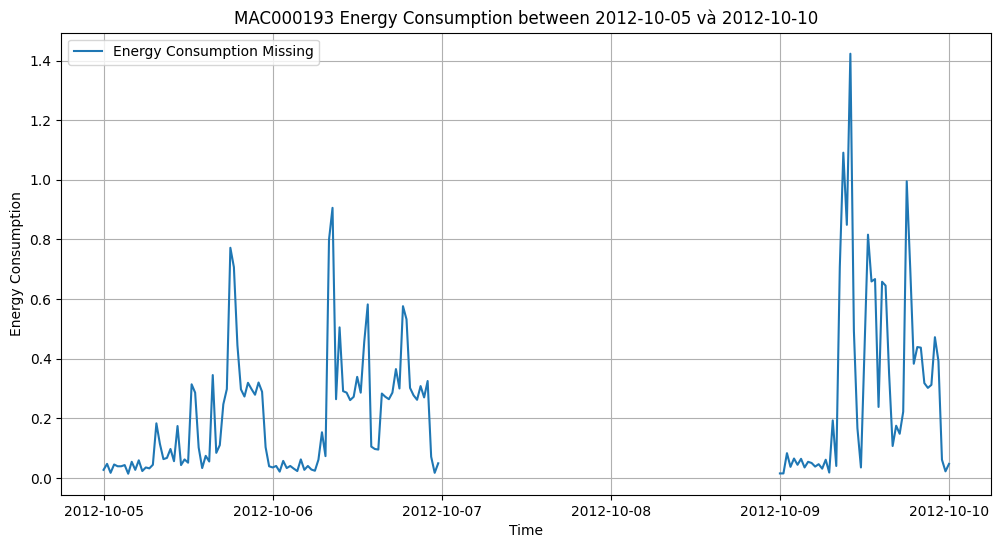

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(ts_df2[vis_window].index, ts_df2[vis_window]["energy_consumption_missing"], label="Energy Consumption Missing")
plt.title(f"MAC000193 Energy Consumption between {vis_window.start.strftime('%Y-%m-%d')} và {vis_window.stop.strftime('%Y-%m-%d')}")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(True)

plt.savefig("/kaggle/working/mac000193_missing.png", bbox_inches="tight")
plt.show()


In [46]:
#Create a column with the Hour from timestamp
ts_df2["hour"] = ts_df2.index.hour
#Calculate hourly average consumption
hourly_profile = ts_df2.groupby(['hour'])['energy_consumption'].mean().reset_index()
hourly_profile.rename(columns={"energy_consumption": "hourly_profile"}, inplace=True)
#Saving the index because it gets lost in merge
idx = ts_df2.index
#Merge the hourly profile dataframe to ts dataframe
ts_df2 = ts_df2.merge(hourly_profile, on=['hour'], how='left', validate="many_to_one")
ts_df2.index = idx

In [47]:
#Using the hourly profile to fill missing
ts_df2['hourly_profile_imputed'] = ts_df2['energy_consumption_missing']
ts_df2['hourly_profile_imputed'] = ts_df2['energy_consumption_missing'].fillna(ts_df2['hourly_profile'])
mae = mean_absolute_error(ts_df2.loc[window, "hourly_profile_imputed"], ts_df2.loc[window, "energy_consumption"])

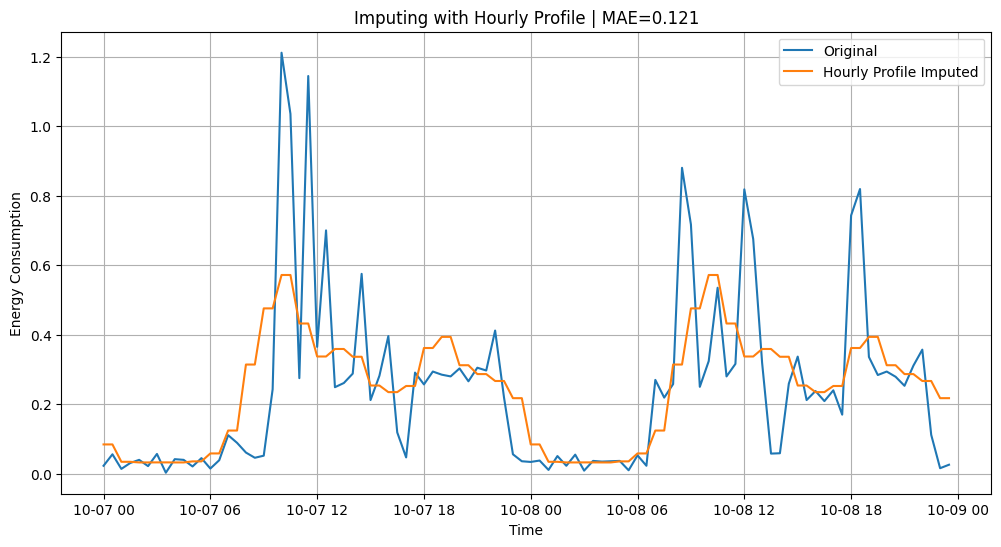

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(
    ts_df2.loc[window].index,
    ts_df2.loc[window, 'energy_consumption'],
    label="Original"
)
plt.plot(
    ts_df2.loc[window].index,
    ts_df2.loc[window, 'hourly_profile_imputed'],
    label="Hourly Profile Imputed"
)

plt.title(f"Imputing with Hourly Profile | MAE={mae:.3f}")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(True)

plt.savefig("/kaggle/working/hourly_profile_imputation.png", bbox_inches="tight")
plt.show()


In [49]:
#Create a column with the weekday from timestamp
ts_df2["weekday"] = ts_df2.index.weekday
#Calculate weekday-hourly average consumption
day_hourly_profile = ts_df2.groupby(['weekday','hour'])['energy_consumption'].mean().reset_index()
day_hourly_profile.rename(columns={"energy_consumption": "day_hourly_profile"}, inplace=True)
#Saving the index because it gets lost in merge
idx = ts_df2.index
#Merge the day-hourly profile dataframe to ts dataframe
ts_df2 = ts_df2.merge(day_hourly_profile, on=['weekday', 'hour'], how='left', validate="many_to_one")
ts_df2.index = idx

In [50]:
#Using the day-hourly profile to fill missing
ts_df2['day_hourly_profile_imputed'] = ts_df2['energy_consumption_missing']
ts_df2['day_hourly_profile_imputed'] = ts_df2['energy_consumption_missing'].fillna(ts_df2['day_hourly_profile'])
mae = mean_absolute_error(ts_df2.loc[window, "day_hourly_profile_imputed"], ts_df2.loc[window, "energy_consumption"])

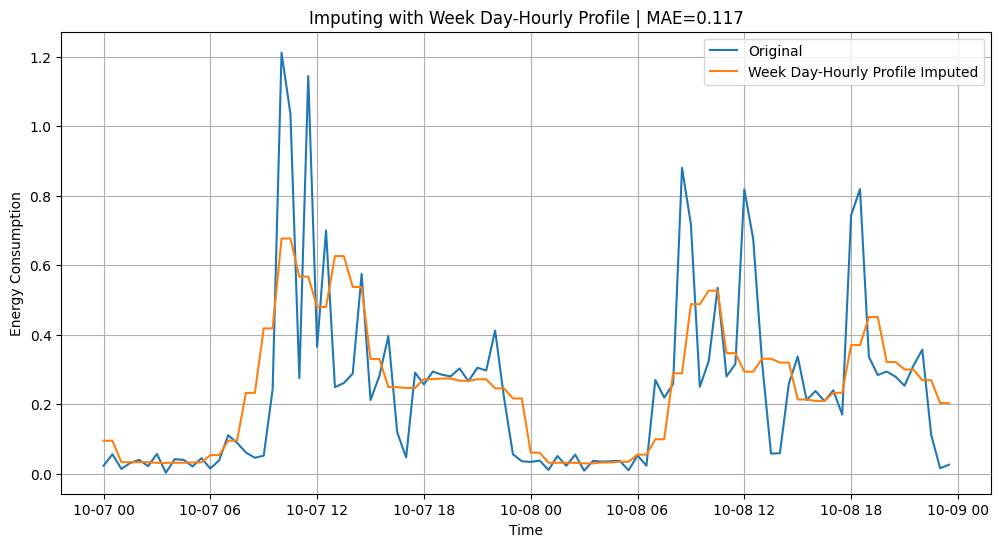

In [51]:
import matplotlib.pyplot as plt

# Dữ liệu
ts_window = ts_df2.loc[window]

plt.figure(figsize=(12,6))
plt.plot(
    ts_window.index,
    ts_window['energy_consumption'],
    label="Original"
)
plt.plot(
    ts_window.index,
    ts_window['day_hourly_profile_imputed'],
    label="Week Day-Hourly Profile Imputed"
)

plt.title(f"Imputing with Week Day-Hourly Profile | MAE={mae:.3f}")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(True)

# Lưu ảnh ra Kaggle working
plt.savefig("/kaggle/working/day_hourly_profile_imputation.png", bbox_inches="tight")
plt.show()


In [52]:
ts_df3 = ts_df.copy()

In [53]:
ts_df3["weekday_name"] = ts_df3.index.day_name()
ts_df3["weekday"] = ts_df3.index.weekday
ts_df3["week"] = ts_df3.index.isocalendar().week
ts_df3["day"] = ts_df3.index.day
ts_df3["hour"] = ts_df3.index.hour
ts_df3["date"] = ts_df3.index.date
ts_df3["month"] = ts_df3.index.month
ts_df3["month_name"] = ts_df3.index.month_name()
ts_df3["year"] = ts_df3.index.year

In [54]:
#Making ordered categoricals to make for sorted plots
ts_df3['month_name'] = pd.Categorical(ts_df3['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df3['weekday_name'] = pd.Categorical(ts_df3['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)

In [55]:
ts_df3

,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,visibility,...,summary,weekday_name,weekday,week,day,hour,date,month,month_name,year
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,MAC000193,0.368,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.99,...,Mostly Cloudy,Sunday,6,52,1,0,2012-01-01,1,January,2012
2012-01-01 00:30:00,MAC000193,0.386,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.99,...,Mostly Cloudy,Sunday,6,52,1,0,2012-01-01,1,January,2012
2012-01-01 01:00:00,MAC000193,0.170,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.89,...,Overcast,Sunday,6,52,1,1,2012-01-01,1,January,2012
2012-01-01 01:30:00,MAC000193,0.021,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.89,...,Overcast,Sunday,6,52,1,1,2012-01-01,1,January,2012
2012-01-01 02:00:00,MAC000193,0.038,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,11.54,...,Mostly Cloudy,Sunday,6,52,1,2,2012-01-01,1,January,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 21:30:00,MAC000193,0.217,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,16.09,...,Clear,Thursday,3,9,27,21,2014-02-27,2,February,2014
2014-02-27 22:00:00,MAC000193,0.169,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,14.00,...,Clear,Thursday,3,9,27,22,2014-02-27,2,February,2014
2014-02-27 22:30:00,MAC000193,0.268,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,14.00,...,Clear,Thursday,3,9,27,22,2014-02-27,2,February,2014


In [56]:
ts_df3 = imputation(ts_df3)
ts_df3

,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,visibility,...,weekday,week,day,hour,date,month,month_name,year,day_hourly_profile,energy_consumption_imputed
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,MAC000193,0.368,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.99,...,6,52,1,0,2012-01-01,1,January,2012,0.094973,0.368
2012-01-01 00:30:00,MAC000193,0.386,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.99,...,6,52,1,0,2012-01-01,1,January,2012,0.094973,0.386
2012-01-01 01:00:00,MAC000193,0.170,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.89,...,6,52,1,1,2012-01-01,1,January,2012,0.033252,0.170
2012-01-01 01:30:00,MAC000193,0.021,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.89,...,6,52,1,1,2012-01-01,1,January,2012,0.033252,0.021
2012-01-01 02:00:00,MAC000193,0.038,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,11.54,...,6,52,1,2,2012-01-01,1,January,2012,0.033372,0.038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 21:30:00,MAC000193,0.217,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,16.09,...,3,9,27,21,2014-02-27,2,February,2014,0.278585,0.217
2014-02-27 22:00:00,MAC000193,0.169,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,14.00,...,3,9,27,22,2014-02-27,2,February,2014,0.263335,0.169
2014-02-27 22:30:00,MAC000193,0.268,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,14.00,...,3,9,27,22,2014-02-27,2,February,2014,0.263335,0.268


In [57]:
ts_df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37872 entries, 2012-01-01 00:00:00 to 2014-02-27 23:30:00
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   LCLid                       37872 non-null  object  
 1   energy_consumption          37823 non-null  float64 
 2   frequency                   37872 non-null  object  
 3   series_length               37872 non-null  int64   
 4   stdorToU                    37872 non-null  object  
 5   Acorn                       37872 non-null  object  
 6   Acorn_grouped               37872 non-null  object  
 7   file                        37872 non-null  object  
 8   holidays                    37872 non-null  object  
 9   visibility                  37872 non-null  float64 
 10  windBearing                 37872 non-null  int64   
 11  temperature                 37872 non-null  float64 
 12  dewPoint                    37872 non-n

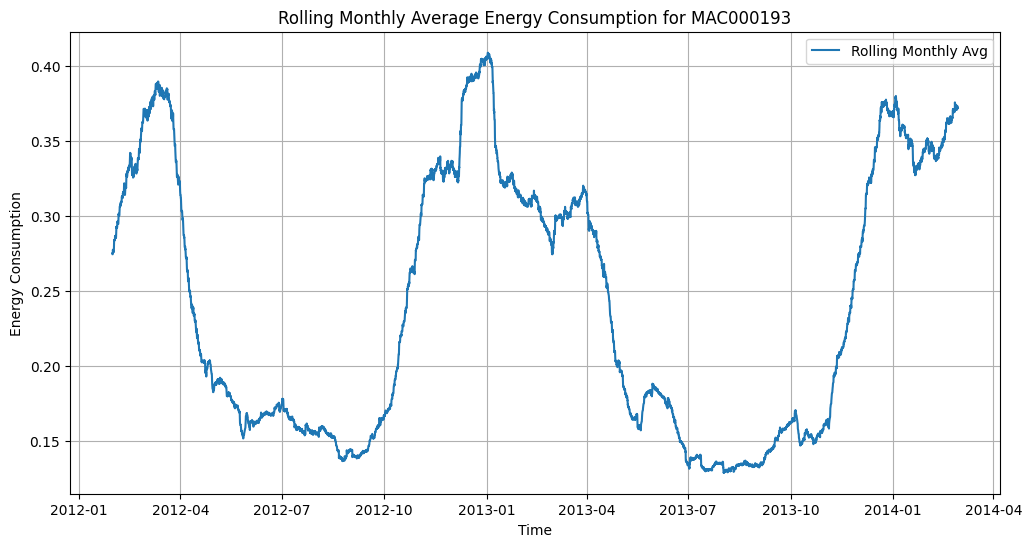

In [58]:
import matplotlib.pyplot as plt

# Tính rolling monthly average
ts_df3["rolling_monthly_avg"] = ts_df3["energy_consumption_imputed"].rolling(window=48*30).mean()

# Vẽ bằng matplotlib
plt.figure(figsize=(12,6))
plt.plot(
    ts_df3.index,
    ts_df3["rolling_monthly_avg"],
    label="Rolling Monthly Avg"
)

plt.title("Rolling Monthly Average Energy Consumption for MAC000193")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(True)

# Lưu hình ra thư mục làm việc
plt.savefig("/kaggle/working/rolling_avg_line_plot.png", bbox_inches="tight")
plt.show()


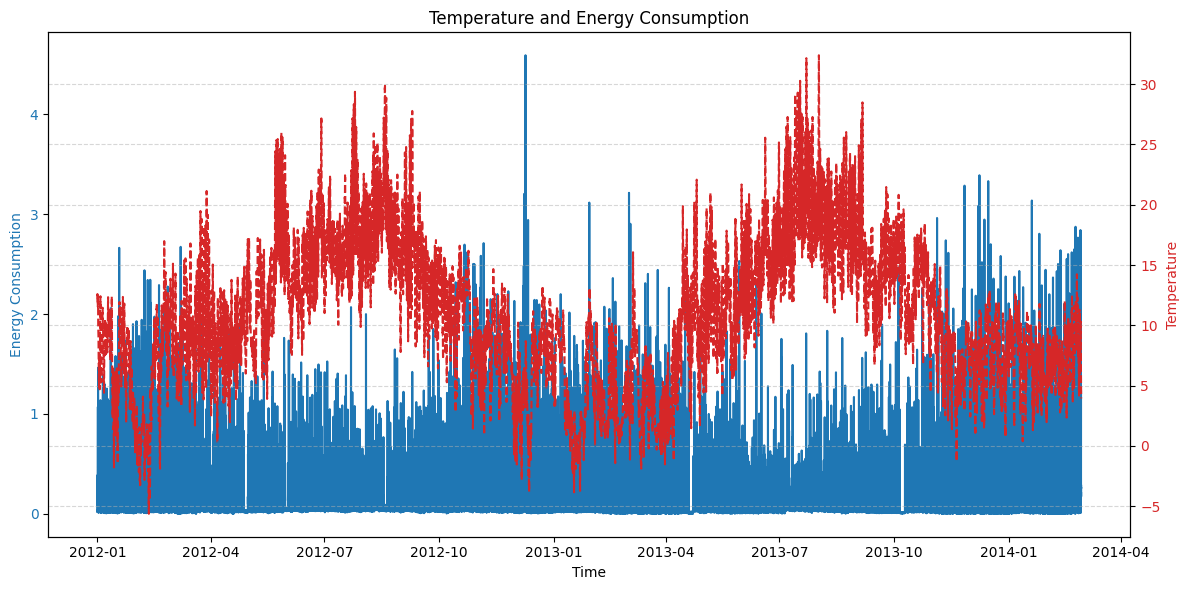

In [59]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

# Trục y1: Energy consumption
ax1.plot(ts_df3.index, ts_df3["energy_consumption_imputed"], color="tab:blue", label="Energy Consumption")
ax1.set_xlabel("Time")
ax1.set_ylabel("Energy Consumption", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Trục y2: Temperature
ax2 = ax1.twinx()
ax2.plot(ts_df3.index, ts_df3["temperature"], color="tab:red", linestyle="--", label="Temperature")
ax2.set_ylabel("Temperature", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Tiêu đề + grid
plt.title("Temperature and Energy Consumption")
fig.tight_layout()
plt.grid(True, which="both", linestyle="--", alpha=0.5)

# Lưu hình ra Kaggle working
plt.savefig("/kaggle/working/temp_vs_energy.png", bbox_inches="tight")
plt.show()


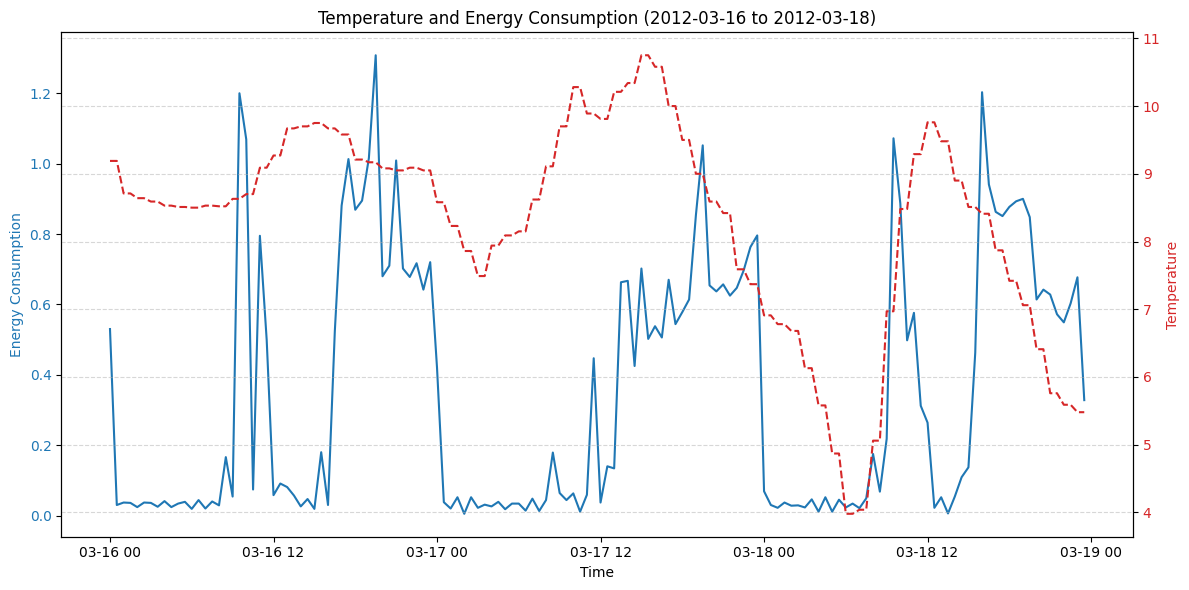

In [60]:
import matplotlib.pyplot as plt

# Chọn khoảng thời gian zoom
zoom_window = slice("2012-03-16", "2012-03-18")
df_zoom = ts_df3.loc[zoom_window]

fig, ax1 = plt.subplots(figsize=(12,6))

# Trục y1: Energy Consumption
ax1.plot(df_zoom.index, df_zoom["energy_consumption_imputed"], color="tab:blue", label="Energy Consumption")
ax1.set_xlabel("Time")
ax1.set_ylabel("Energy Consumption", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Trục y2: Temperature (dùng linestyle="--" để giống dash_secondary=True)
ax2 = ax1.twinx()
ax2.plot(df_zoom.index, df_zoom["temperature"], color="tab:red", linestyle="--", label="Temperature")
ax2.set_ylabel("Temperature", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Tiêu đề + grid
plt.title("Temperature and Energy Consumption (2012-03-16 to 2012-03-18)")
fig.tight_layout()
plt.grid(True, which="both", linestyle="--", alpha=0.5)

# Lưu hình ra Kaggle working
plt.savefig("/kaggle/working/temp_vs_energy_zoomed.png", bbox_inches="tight")
plt.show()


In [61]:
#Montlhly Average energy consumption
plot_df = ts_df3[~ts_df3.year.isin([2011, 2014])].groupby(["year", "month_name"])[['energy_consumption_imputed',"temperature"]].mean().reset_index()

/tmp/ipykernel_36/2962810846.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df = ts_df3[~ts_df3.year.isin([2011, 2014])].groupby(["year", "month_name"])[['energy_consumption_imputed',"temperature"]].mean().reset_index()


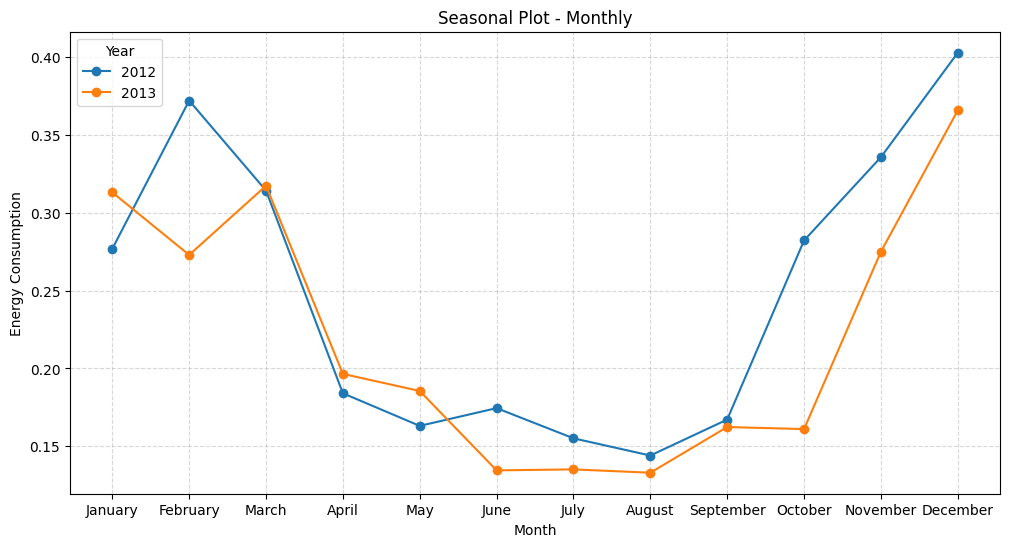

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Vẽ từng năm một
for year, group in plot_df.groupby("year"):
    plt.plot(group["month_name"], group["energy_consumption_imputed"], marker="o", label=str(year))

plt.title("Seasonal Plot - Monthly")
plt.xlabel("Month")
plt.ylabel("Energy Consumption")
plt.legend(title="Year")
plt.grid(True, linestyle="--", alpha=0.5)

# Lưu hình
plt.savefig("/kaggle/working/seasonal_plot_monthly.png", bbox_inches="tight")
plt.show()


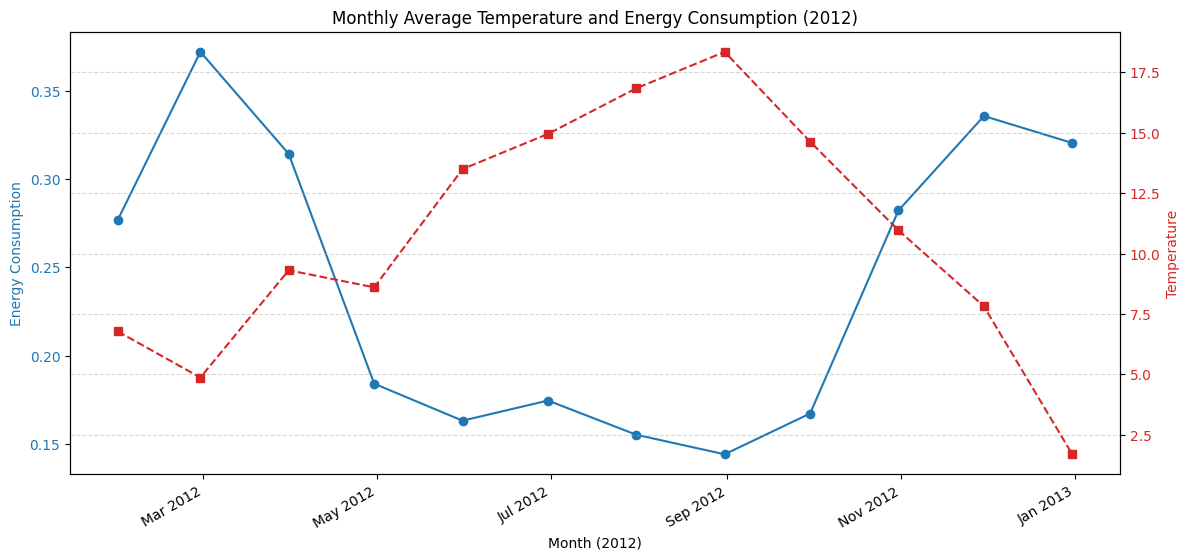

In [63]:
import matplotlib.pyplot as plt

zoom_year_2012 = slice("2012-01-01", "2012-12-01")

# Chỉ lấy cột numeric và resample theo tháng
numeric_cols = ts_df3[zoom_year_2012].select_dtypes(exclude=['category']).columns
monthly_data_2012 = ts_df3[zoom_year_2012][numeric_cols].resample('ME').mean(numeric_only=True)

fig, ax1 = plt.subplots(figsize=(12,6))

# Trục y1: Energy Consumption
ax1.plot(monthly_data_2012.index, monthly_data_2012["energy_consumption_imputed"],
         color="tab:blue", marker="o", label="Energy Consumption")
ax1.set_xlabel("Month (2012)")
ax1.set_ylabel("Energy Consumption", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Trục y2: Temperature (dashed line vì dash_secondary=True)
ax2 = ax1.twinx()
ax2.plot(monthly_data_2012.index, monthly_data_2012["temperature"],
         color="tab:red", linestyle="--", marker="s", label="Temperature")
ax2.set_ylabel("Temperature", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Tiêu đề
plt.title("Monthly Average Temperature and Energy Consumption (2012)")

# Grid + layout
fig.tight_layout()
plt.grid(True, which="both", linestyle="--", alpha=0.5)

# Xử lý format trục X thành tên tháng
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate()

# Lưu file
plt.savefig("/kaggle/working/temp_vs_energy_zoomed_2012.png", bbox_inches="tight")
plt.show()


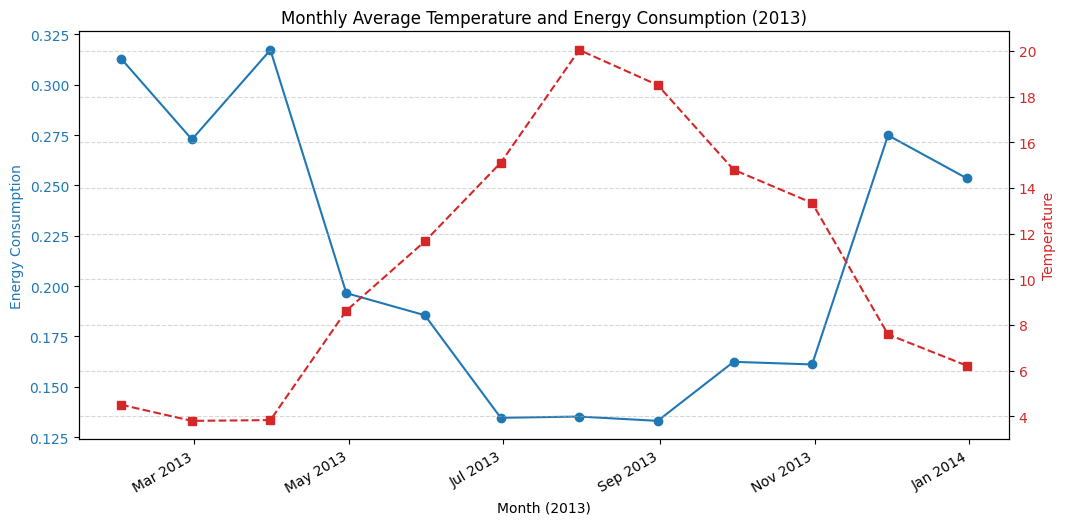

In [64]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

zoom_year_2013 = slice("2013-01-01", "2013-12-01")

# Chỉ lấy cột numeric và resample theo tháng
numeric_cols = ts_df3[zoom_year_2013].select_dtypes(exclude=['category']).columns
monthly_data_2013 = ts_df3[zoom_year_2013][numeric_cols].resample('ME').mean(numeric_only=True)

fig, ax1 = plt.subplots(figsize=(12,6))

# Trục y1: Energy Consumption
ax1.plot(monthly_data_2013.index, monthly_data_2013["energy_consumption_imputed"],
         color="tab:blue", marker="o", label="Energy Consumption")
ax1.set_xlabel("Month (2013)")
ax1.set_ylabel("Energy Consumption", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Trục y2: Temperature (dashed line vì dash_secondary=True)
ax2 = ax1.twinx()
ax2.plot(monthly_data_2013.index, monthly_data_2013["temperature"],
         color="tab:red", linestyle="--", marker="s", label="Temperature")
ax2.set_ylabel("Temperature", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Tiêu đề
plt.title("Monthly Average Temperature and Energy Consumption (2013)")

# Grid + format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate()
plt.grid(True, linestyle="--", alpha=0.5)

# Lưu file
plt.savefig("/kaggle/working/temp_vs_energy_zoomed_2013.png", bbox_inches="tight")
plt.show()


In [65]:
plot_df = ts_df3.groupby(["date","weekday_name", "hour"])["energy_consumption"].mean().reset_index().dropna()

/tmp/ipykernel_36/4188232335.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df = ts_df3.groupby(["date","weekday_name", "hour"])["energy_consumption"].mean().reset_index().dropna()


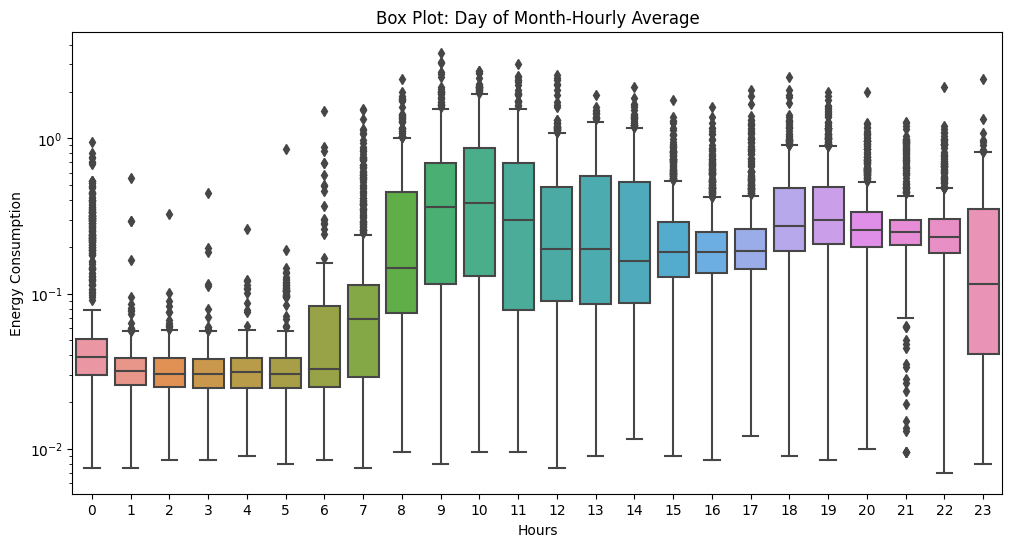

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(data=plot_df, x="hour", y="energy_consumption")

plt.yscale("log")  # log_y=True
plt.title("Box Plot: Day of Month-Hourly Average")
plt.xlabel("Hours")
plt.ylabel("Energy Consumption")

plt.savefig("/kaggle/working/box_plot_hourly_avg.png", bbox_inches="tight")
plt.show()


In [67]:
plot_df = pd.pivot_table(ts_df3, index="weekday_name", values='energy_consumption', columns="hour", aggfunc="mean")

/tmp/ipykernel_36/1586138872.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  plot_df = pd.pivot_table(ts_df3, index="weekday_name", values='energy_consumption', columns="hour", aggfunc="mean")


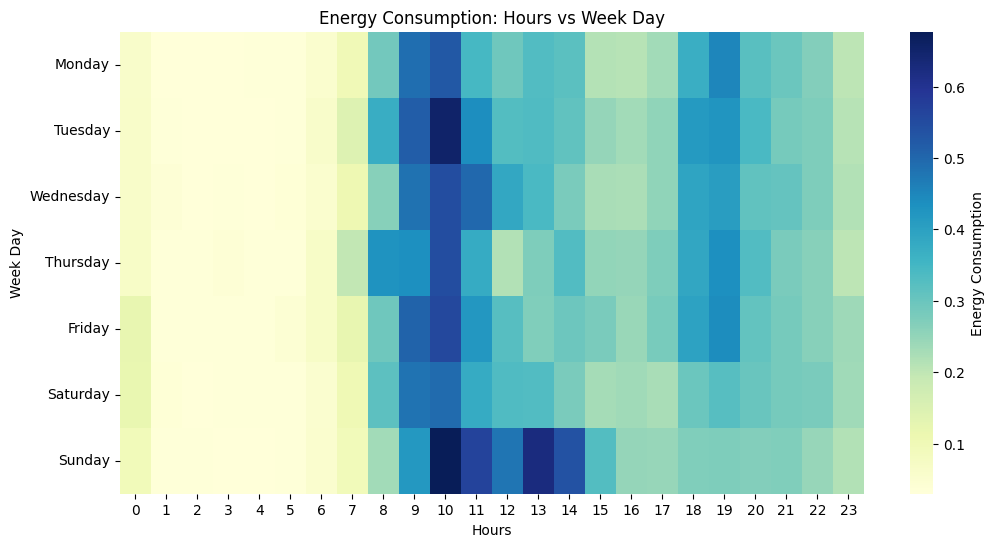

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(plot_df, cmap="YlGnBu", cbar_kws={'label': 'Energy Consumption'})

plt.title("Energy Consumption: Hours vs Week Day")
plt.xlabel("Hours")
plt.ylabel("Week Day")

plt.savefig("/kaggle/working/hour_weekday_heatmap.png", bbox_inches="tight")
plt.show()


In [69]:
#Does not support misssing values, so using imputed ts instead
res = seasonal_decompose(ts_df3['energy_consumption_imputed'], period=7*48, model="additive", extrapolate_trend="freq", filt=np.repeat(1/(30*48), 30*48))

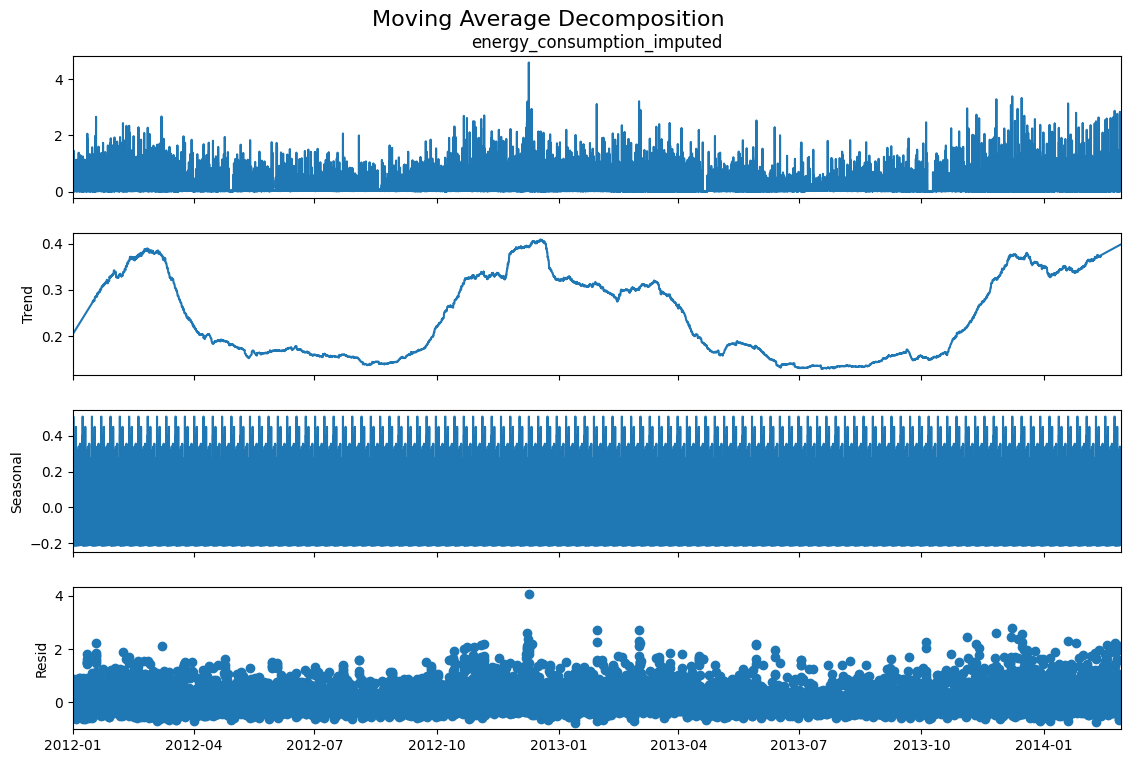

In [70]:
import matplotlib.pyplot as plt

# Nếu đã có res từ seasonal_decompose
fig = res.plot()
fig.set_size_inches(12, 8)

plt.suptitle("Moving Average Decomposition", fontsize=16)
plt.savefig("/kaggle/working/moving_avg_decomposition.png", bbox_inches="tight")
plt.show()


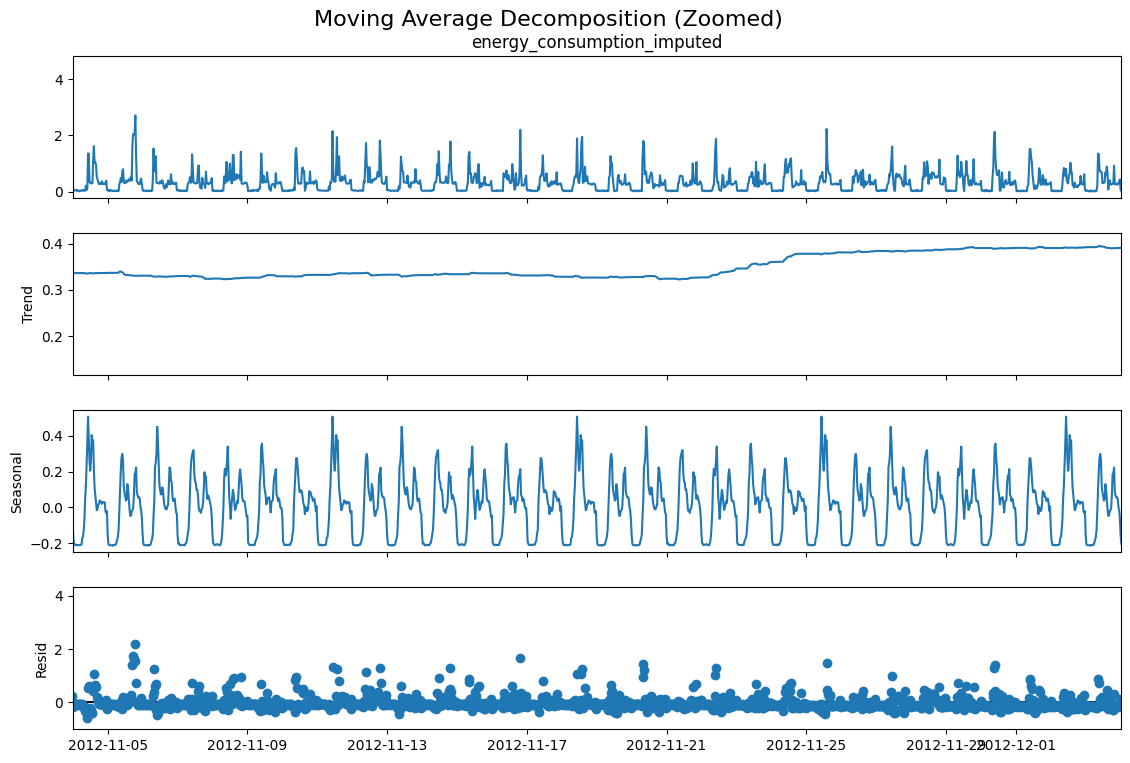

In [71]:
import matplotlib.pyplot as plt

fig = res.plot()
fig.set_size_inches(12, 8)

# Zoom trục x cho tất cả subplot
for ax in fig.axes:
    ax.set_xlim(pd.to_datetime("2012-11-04"), pd.to_datetime("2012-12-04"))

plt.suptitle("Moving Average Decomposition (Zoomed)", fontsize=16)
plt.savefig("/kaggle/working/moving_avg_decomposition_zoomed.png", bbox_inches="tight")
plt.show()


In [72]:
exp_block_df.head()

,timestamp,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,2012-01-01 00:00:00,MAC000050,0.175,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
1,2012-01-01 00:30:00,MAC000050,0.212,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
2,2012-01-01 01:00:00,MAC000050,0.313,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
3,2012-01-01 01:30:00,MAC000050,0.302,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
4,2012-01-01 02:00:00,MAC000050,0.257,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,229,12.45,11.04,1007.95,12.45,5.31,rain,partly-cloudy-night,0.91,Mostly Cloudy


In [73]:
ts_df_mstl = exp_block_df[exp_block_df.LCLid=="MAC000050"][['timestamp','energy_consumption']].set_index('timestamp')
ts_df_mstl = imputation(ts_df_mstl)
ts_df_mstl.head()

,energy_consumption,hour,weekday,day_hourly_profile,energy_consumption_imputed
timestamp,,,,,
2012-01-01 00:00:00,0.175,0,6,0.237625,0.175
2012-01-01 00:30:00,0.212,0,6,0.237625,0.212
2012-01-01 01:00:00,0.313,1,6,0.135279,0.313
2012-01-01 01:30:00,0.302,1,6,0.135279,0.302
2012-01-01 02:00:00,0.257,2,6,0.117706,0.257


In [74]:
stl_kwargs = {"seasonal_deg": 0, }
mstl = MSTL(ts_df_mstl['energy_consumption_imputed'],
            periods=[48, 48*7],
            #windows=[101, 101],  # Setting this large along with `seasonal_deg=0` will force the seasonality to be periodic.
            #stl_kwargs = stl_kwargs,
            )
res = mstl.fit()

In [75]:
res.trend.head()

timestamp
2012-01-01 00:00:00    0.728921
2012-01-01 00:30:00    0.728886
2012-01-01 01:00:00    0.728851
2012-01-01 01:30:00    0.728815
2012-01-01 02:00:00    0.728779
Name: trend, dtype: float64

In [76]:
res.seasonal.head()

,seasonal_48,seasonal_336
timestamp,,
2012-01-01 00:00:00,-0.670997,0.306593
2012-01-01 00:30:00,-0.514085,0.016823
2012-01-01 01:00:00,-0.544906,0.099274
2012-01-01 01:30:00,-0.535217,0.038988
2012-01-01 02:00:00,-0.552320,0.035324


In [77]:
res.resid.head()

timestamp
2012-01-01 00:00:00   -0.189517
2012-01-01 00:30:00   -0.019623
2012-01-01 01:00:00    0.029782
2012-01-01 01:30:00    0.069415
2012-01-01 02:00:00    0.045216
Name: resid, dtype: float64

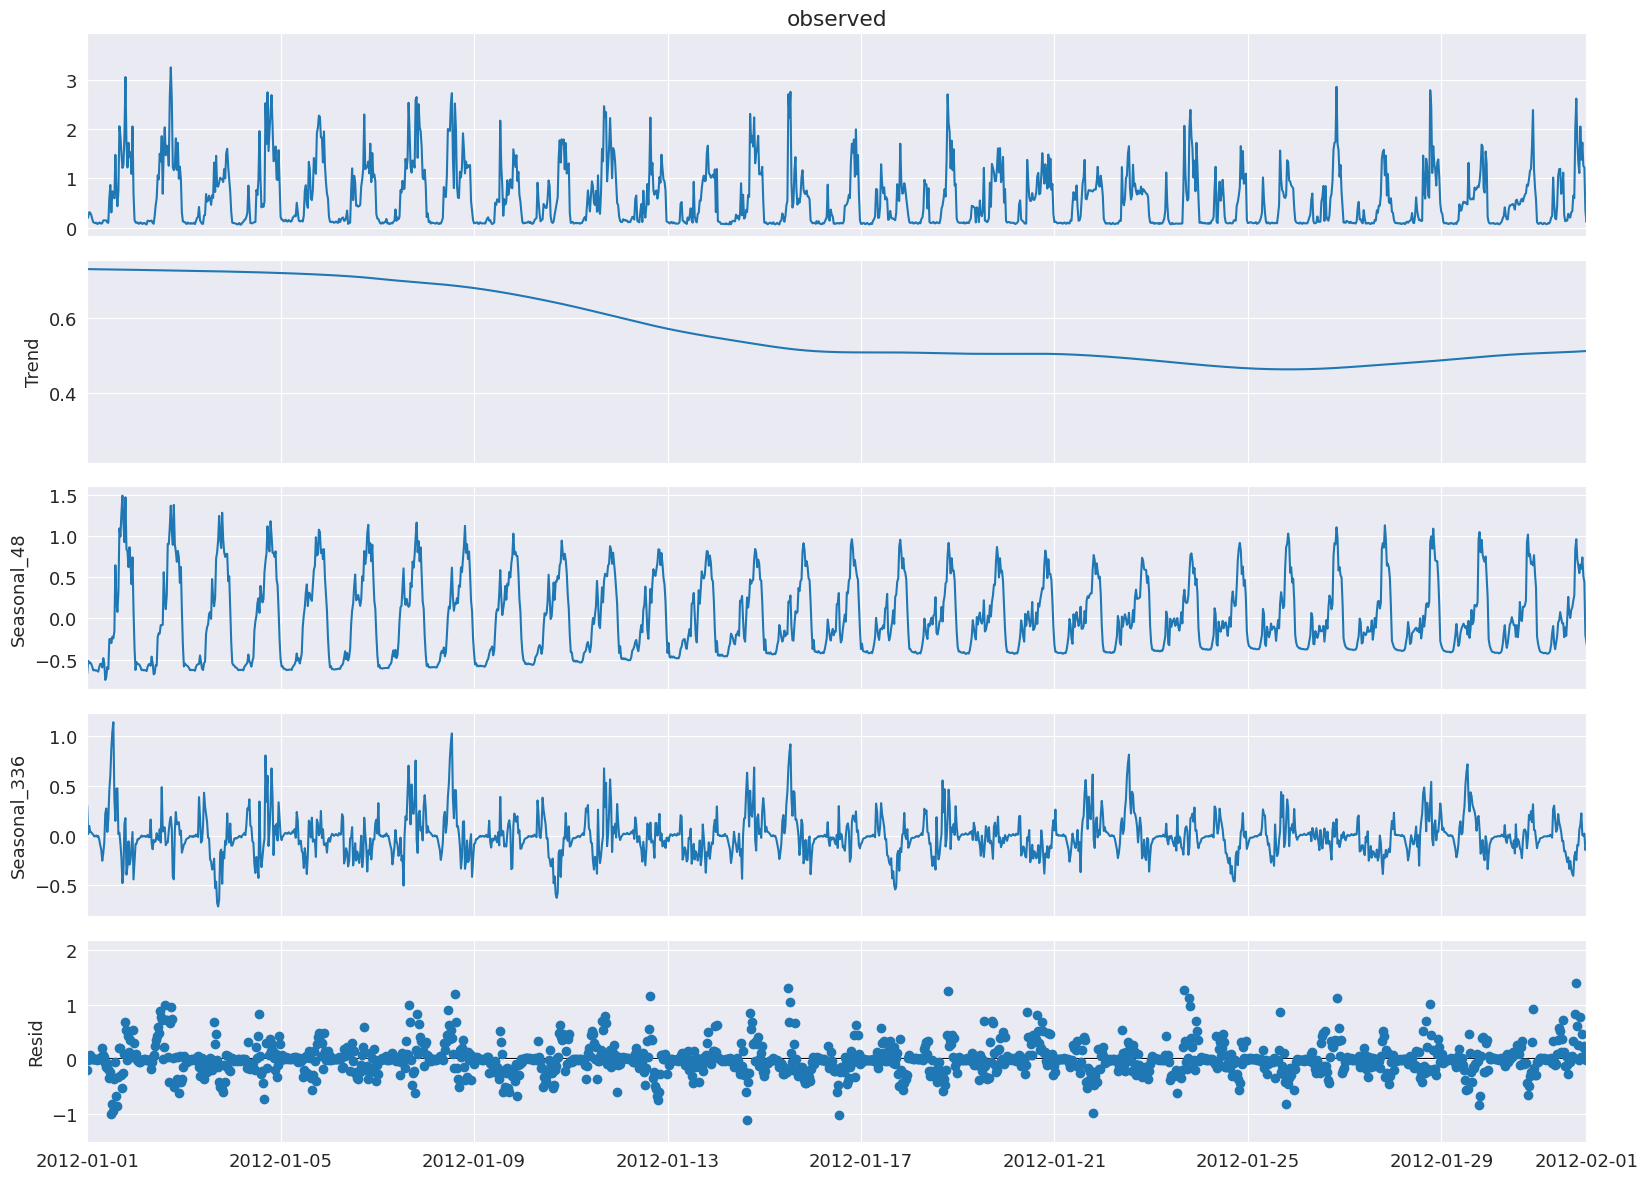

In [78]:
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

# Creating a plot
fig = res.plot()

for ax in fig.axes:
    ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-02-01'))
#plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

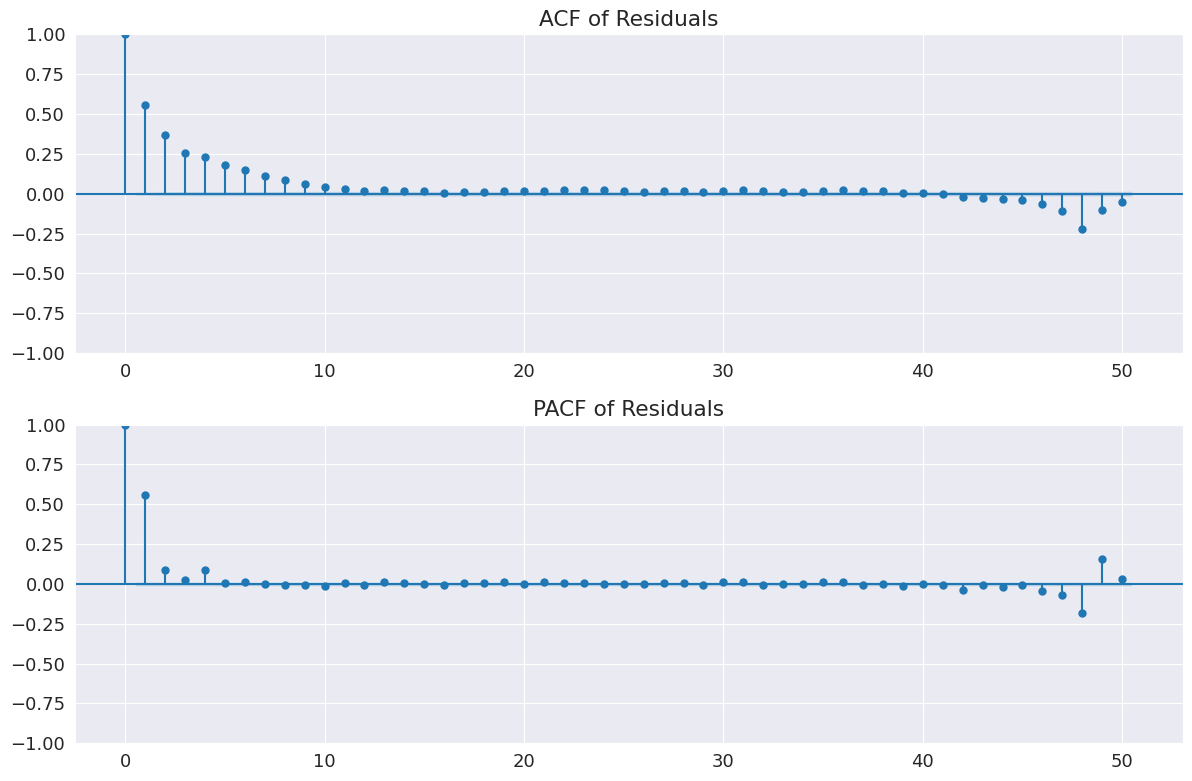

In [79]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(12,8))

# ACF
plot_acf(res.resid.dropna(), ax=axes[0], lags=50, title="ACF of Residuals")

# PACF
plot_pacf(res.resid.dropna(), ax=axes[1], lags=50, title="PACF of Residuals")

plt.tight_layout()
plt.savefig("/kaggle/working/acf_pacf.png", bbox_inches="tight")
plt.show()


In [70]:
# Perform Augmented Dickey-Fuller test
# 'result' contains the test statistic and the p-value.
result = adfuller(ts_df_mstl.energy_consumption_imputed)
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

p-value: 0.000000
Evidence suggests that the time series is stationary.
